### Testing the LESS denoising code on mock data

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
import torch
import sys
import os
less_path = os.path.abspath(os.path.join("..", "LESS_ver_alpha"))
if less_path not in sys.path:
    sys.path.insert(0, less_path)
from less import denoise
from utils import set_seed
from scipy.ndimage import gaussian_filter1d

In [2]:
def run_less_denoising(movie_np: np.ndarray,
                           patch_size: int = 16,
                           top_k: int = 18,
                           window_size: int = 37,
                           stride: int = 4,
                           pat: int = 5,
                           seed: int = 42,
                           verbose: bool = False) -> np.ndarray:
    """
    Run LESS denoising on a NumPy movie array.

    Parameters:
        movie_np (np.ndarray): Input movie of shape (T, H, W)
        patch_size (int): Patch size
        top_k (int): Number of best-matching patches
        window_size (int): Search window size
        stride (int): Stride for patch selection
        pat (int): Temporal patch size (number of adjacent frames)
        seed (int): Random seed
        verbose (bool): Whether to print progress

    Returns:
        np.ndarray: Denoised movie of shape (T, H, W)
    """
    assert movie_np.ndim == 3, "Input movie must have shape (T, H, W)"
    set_seed(seed)

    movie_tensor = torch.from_numpy(movie_np).float()

    denoised_tensor = denoise(
        data=movie_tensor,
        cuda=False,               # Force CPU
        patch_size=patch_size,
        top_k=top_k,
        window_size=window_size,
        stride=stride,
        pat=pat,
        verbose=verbose
    )

    return denoised_tensor.numpy()

In [3]:
def show_movies(original, noisy, denoised, fps=30):
    """
    Display three movies side by side: original, noisy, and denoised.

    Parameters:
        original (np.ndarray): Original signal (T, H, W)
        noisy (np.ndarray): Noisy input movie (T, H, W)
        denoised (np.ndarray): Denoised movie (T, H, W)
        fps (int): Frames per second
    """
    assert original.shape == noisy.shape == denoised.shape, "All movies must have the same shape"
    T, H, W = original.shape
    vmin = min(original.min(), noisy.min(), denoised.min())
    vmax = max(original.max(), noisy.max(), denoised.max())

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    ims = []

    titles=("Original", "Noisy", "Denoised")
    for ax, title in zip(axes, titles):
        im = ax.imshow(original[0], cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(title)
        ax.axis("off")
        ims.append(im)

    def update(i):
        ims[0].set_array(original[i])
        ims[1].set_array(noisy[i])
        ims[2].set_array(denoised[i])
        return ims

    ani = animation.FuncAnimation(fig, update, frames=T, interval=1000/fps, blit=True)
    return ani

In [4]:
def denoise_and_plot(movie_clean, noise, fps, **kwargs):
    """
    Combine signal and noise, run denoising, plot side-by-side.
    
    Parameters:
        movie_clean (ndarray): Clean synthetic movie (T, H, W)
        noise (ndarray): Noise to add (same shape as movie_clean)
        fps (int): Frames per second
        **kwargs: Additional arguments to pass to run_less_denoising
                  (e.g., patch_size=16, seed=123)
    """
    movie_noisy = movie_clean + noise
    movie_denoised = run_less_denoising(movie_noisy, verbose=False, **kwargs)
    ani = show_movies(movie_clean, movie_noisy, movie_denoised, fps=fps)
    return ani

In [5]:
# Setting up t, X, Y grid
T = 300             # Number of time points
H, W = 100, 100     # Spatial resolution (height × width)
fps = 30            # Frame rate

Y, X = np.meshgrid(np.linspace(0, 1, H), np.linspace(0, 1, W), indexing='ij')
t = np.linspace(0, T / fps, T)

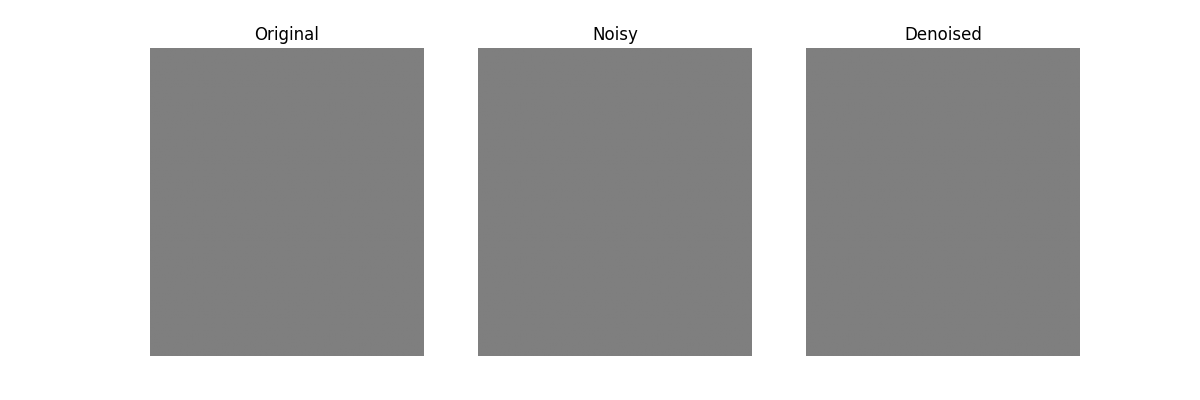

In [6]:
region1 = np.exp(-((X - 0.3)**2 + (Y - 0.3)**2) / 0.02)     # Gaussian bump centered at top-left
signal1 = np.sin(2 * np.pi * 5 * t)                         # 5 Hz oscillation (theta range)
movie_clean = np.zeros((T, H, W))                           # Combine into clean movie
for i in range(T):
    movie_clean[i] = signal1[i] * region1 

noise = np.random.normal(0, 0.5, size=movie_clean.shape)    # Add Gaussian nosie

ani = denoise_and_plot(movie_clean, noise, fps)

In [ ]:
### Gaussian bump with 5 Hz oscillation (theta band)
region1 = np.exp(-((X - 0.3)**2 + (Y - 0.3)**2) / 0.02)
signal1 = np.sin(2 * np.pi * 5 * t)  # 5 Hz
gaussian_bump = np.array([s * region1 for s in signal1])

### Traveling wave (left to right)
speed = 2.0  # units per second
travelling_wave = np.sin(2 * np.pi * (5 * t[:, None, None] - X[None, :, :] * speed))

### Whole-brain global sine wave (e.g., delta band)
global_signal = np.sin(2 * np.pi * 2 * t)  # 2 Hz
whole_brain_wave = np.array([g * np.ones_like(X) for g in global_signal])

### Burst oscillation (10 Hz only in middle ⅓ of time)
region = np.exp(-((X - 0.5)**2 + (Y - 0.5)**2) / 0.02)
signal = np.zeros(T)
burst = (t > 3) & (t < 6)
signal[burst] = np.sin(2 * np.pi * 10 * t[burst])
burst = np.array([s * region for s in signal])

In [8]:
### Gaussian noise
gaussian_noise = np.random.normal(0, 0.5, size=burst.shape)

### Temporally correlated noise (low-pass filtered)
correlated_noise = np.random.normal(0, 1, size=movie_clean.shape)
correlated_noise = gaussian_filter1d(correlated_noise, sigma=3, axis=0)

### Spatially structured noise (slow spatial variation)
noise = np.random.normal(0, 0.5, size=movie_clean.shape)
for i in range(T):
    noise[i] = gaussian_filter1d(noise[i], sigma=5)

### Flicker noise (abrupt jumps)
flicker_noise = np.zeros_like(burst)
for i in range(T):
    if np.random.rand() < 0.1:
        flicker_noise[i] = np.random.normal(0, 0.8, size=(H, W))

### Slow baseline drift
drift = np.linspace(0, 1, T)[:, None, None]
drift_noise = 0.1 * drift * np.ones_like(X)[None, :, :]

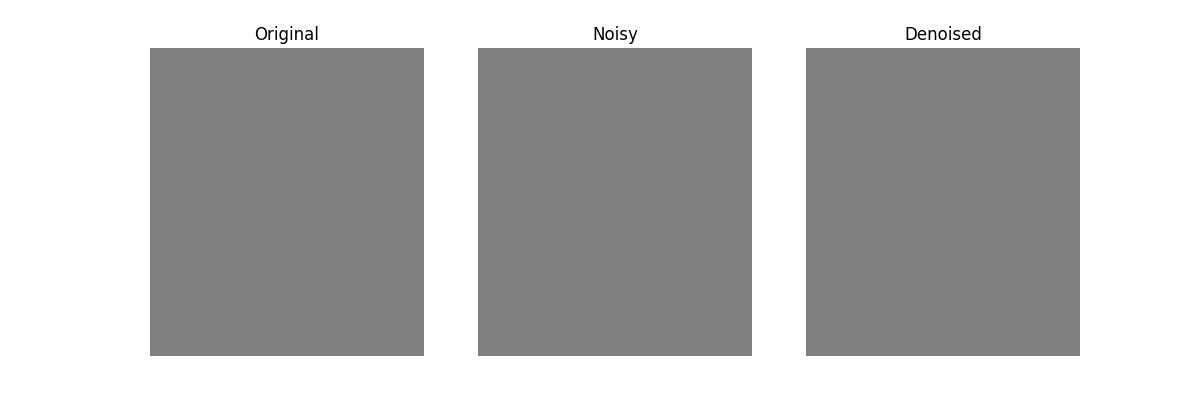

In [10]:
ani = denoise_and_plot(burst, gaussian_noise, fps)